In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install lifetimes

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 584.2/584.2 kB 3.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.2 MB/s eta 0:00:00


In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
import plotly.express as px
import xlrd
import pandas as pd
import datetime
import lifetimes
from lifetimes import BetaGeoFitter
from lifetimes.utils import summary_data_from_transaction_data
from lifetimes.plotting import plot_frequency_recency_matrix
from lifetimes.plotting import plot_probability_alive_matrix
from lifetimes.plotting import plot_period_transactions
from lifetimes.utils import calibration_and_holdout_data
from lifetimes.plotting import *
from sklearn.metrics import mean_squared_error
from math import sqrt
from lifetimes import ParetoNBDFitter
from lifetimes.plotting import plot_history_alive
import pickle
from lifetimes import ModifiedBetaGeoFitter
import warnings
warnings.filterwarnings("ignore")
sns.set_theme(style = "darkgrid")

In [4]:
from sklearn.metrics import mean_squared_error, r2_score

def smape(y_true, y_pred):
    difference = abs(y_true - y_pred)
    denominator = (abs(y_true) + abs(y_pred))/2
    return np.mean(np.where(denominator==0, 0, difference/denominator))

# Data

In [5]:
data = pd.read_csv('/content/drive/MyDrive/BA - Project 2/Data/CDNow')
data

,id,zone,state,gender,age_category,age,date,cds,amt
0,1,Pacific,Oregon,M,young,26,1997-01-01,1,11.77
1,2,Eastern,New Jersey,M,medium,36,1997-01-12,1,12.00
2,2,Eastern,New Jersey,M,medium,36,1997-01-12,5,77.00
3,3,Central,Minnesota,M,young,17,1997-01-02,2,20.76
4,3,Central,Minnesota,M,young,17,1997-03-30,2,20.76
...,...,...,...,...,...,...,...,...,...
69654,23568,Eastern,New Jersey,F,medium,44,1997-04-05,4,83.74
69655,23568,Eastern,New Jersey,F,medium,44,1997-04-22,1,14.99
69656,23569,Mountain,Utah,M,old,63,1997-03-25,2,25.74
69657,23570,Central,Illinois,F,young,21,1997-03-25,3,51.12


In [ ]:
print(data['date'].min())
print(data['date'].max())

1997-01-01
1998-06-30


In [6]:
rfm = summary_data_from_transaction_data(transactions=data,
                                         customer_id_col='id',
                                         datetime_col='date',
                                         monetary_value_col = 'amt',
                                         observation_period_end=pd.to_datetime('1998-06-30'))

rfm.head(3)

,frequency,recency,T,monetary_value
id,,,,
1,0.0,0.0,545.0,0.00
2,0.0,0.0,534.0,0.00
3,5.0,511.0,544.0,27.14


In [7]:
rfm_cal_holdout = calibration_and_holdout_data(transactions=data,
                                               customer_id_col='id',
                                               datetime_col='date',
                                               monetary_value_col = 'amt',
                                               calibration_period_end='1998-03-22',
                                               observation_period_end='1998-06-30' )

rfm_cal_holdout.head(3)

,frequency_cal,recency_cal,T_cal,monetary_value_cal,frequency_holdout,monetary_value_holdout,duration_holdout
id,,,,,,,
1,0.0,0.0,445.0,0.0000,0.0,0.00,100.0
2,0.0,0.0,434.0,0.0000,0.0,0.00,100.0
3,4.0,327.0,444.0,29.6775,1.0,16.99,100.0


# FIT BG MODEL

In [8]:
# instantiation of BG-NBD model
bgf = BetaGeoFitter(penalizer_coef=0.0)

# fitting of BG-NBD model
bgf.fit(frequency=rfm_cal_holdout['frequency_cal'],
        recency=rfm_cal_holdout['recency_cal'],
        T=rfm_cal_holdout['T_cal'])

<lifetimes.BetaGeoFitter: fitted with 23570 subjects, a: 0.47, alpha: 41.30, b: 1.94, r: 0.27>

In [9]:
bgf.summary

,coef,se(coef),lower 95% bound,upper 95% bound
r,0.271528,0.003908,0.263869,0.279188
alpha,41.296181,0.980801,39.373811,43.218551
a,0.474794,0.028335,0.419259,0.530330
b,1.941545,0.149980,1.647583,2.235506


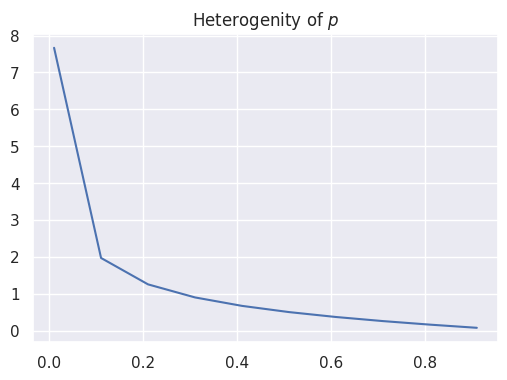

mean:  0.19649323434019686
median:  0.11414006179621929
std:  0.21497505707565262


In [10]:
from scipy.stats import gamma, beta

x = np.arange (0.01, 1, 0.1)
a, b = bgf.params_['a'], bgf.params_['b']
gbd = beta.pdf(x, a, b)
plt.figure(figsize=(6,4))
plt.title('Heterogenity of $p$')
temp = plt.plot(x, gbd)
plt.show()
print('mean: ', beta.mean(a, b))
print('median: ', beta.median(a, b))
print('std: ', beta.std(a, b))

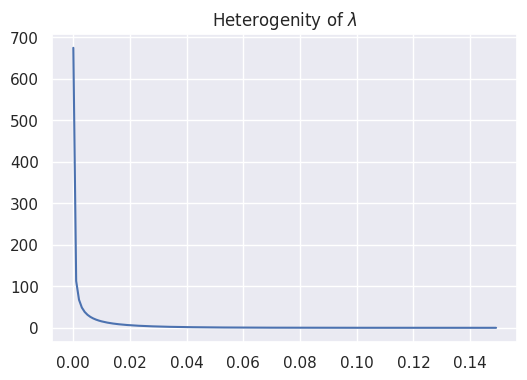

mean:  0.006575145968893099
median:  0.0013480305894410809
std:  0.012618210094039475


In [11]:
x = np.arange (0.0001, 0.15, 0.001)
r, alpha = bgf.params_['r'], bgf.params_['alpha']
ggd = gamma.pdf(x, r, scale=1.0/alpha)
plt.figure(figsize=(6,4))
plt.title('Heterogenity of $\lambda$')
temp = plt.plot(x, ggd)
plt.show()
print('mean: ', gamma.mean(r, scale=1.0/alpha))
print('median: ', gamma.median(r, scale=1.0/alpha))
print('std: ', gamma.std(r, scale=1.0/alpha))

**Frequency-recency matrix**

<Axes: title={'center': 'Expected Number of Future Purchases for 1 Unit of Time,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

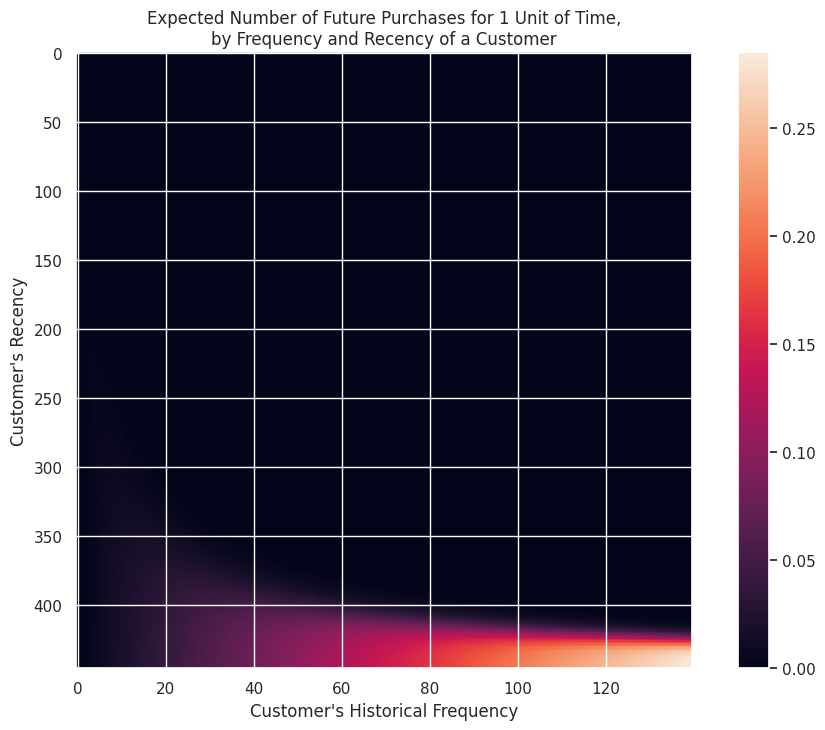

In [12]:
fig = plt.figure(figsize=(12,8))
plot_frequency_recency_matrix(bgf)

**Churn/Active Probability**

<Axes: title={'center': 'Probability Customer is Alive,\nby Frequency and Recency of a Customer'}, xlabel="Customer's Historical Frequency", ylabel="Customer's Recency">

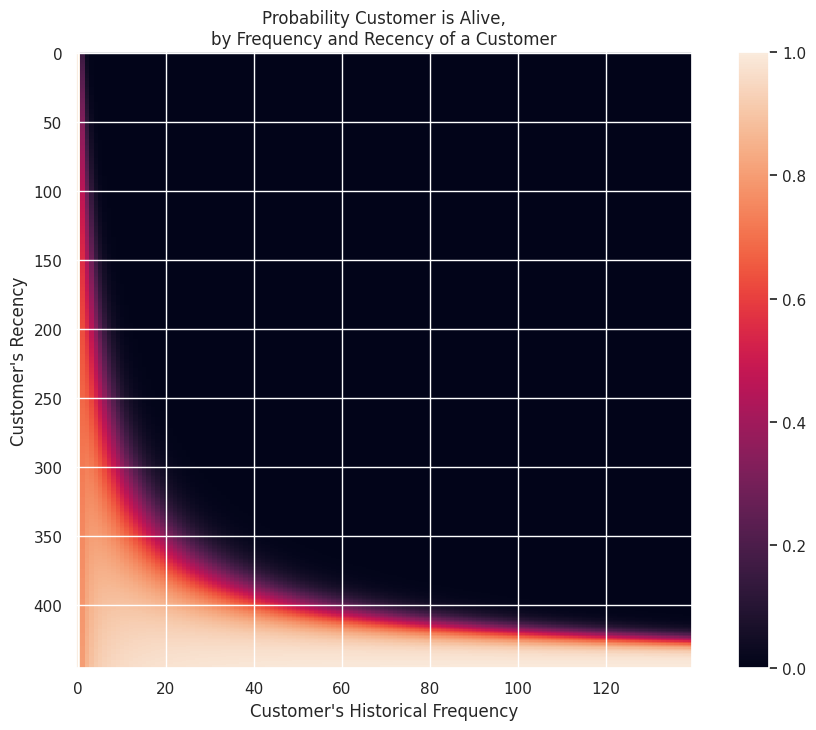

In [13]:
fig = plt.figure(figsize=(12,8))
plot_probability_alive_matrix(bgf)

**Predict in 1 month**

In [14]:
tm = 30
rfm['predicted_purchases'] = bgf.conditional_expected_number_of_purchases_up_to_time(tm, rfm['frequency'], rfm['recency'], rfm['T'])

In [15]:
rfm.sort_values(by='predicted_purchases').tail(5)

,frequency,recency,T,monetary_value,predicted_purchases
id,,,,,
19597,94.0,465.0,477.0,24.704894,5.150160
22061,115.0,456.0,467.0,32.656609,6.385965
7983,124.0,507.0,512.0,56.038790,6.577091
7592,145.0,516.0,517.0,95.984276,7.677447
14048,170.0,496.0,496.0,52.773765,9.359256


<Axes: title={'center': 'Frequency of Repeat Transactions'}, xlabel='Number of Calibration Period Transactions', ylabel='Customers'>

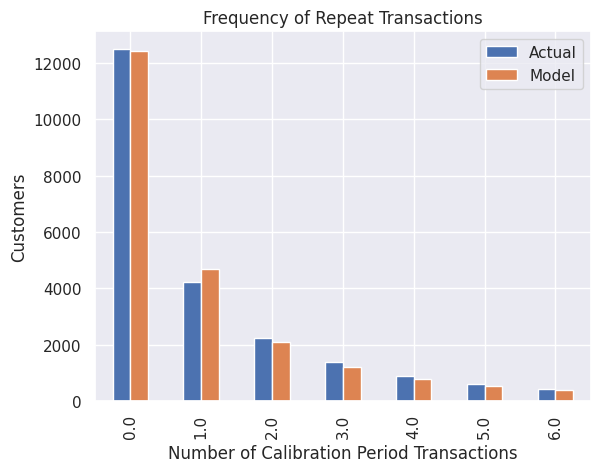

In [16]:
plot_period_transactions(bgf)

<Axes: title={'center': 'Actual Purchases in Holdout Period vs Predicted Purchases'}, xlabel='Purchases in calibration period', ylabel='Average of Purchases in Holdout Period'>

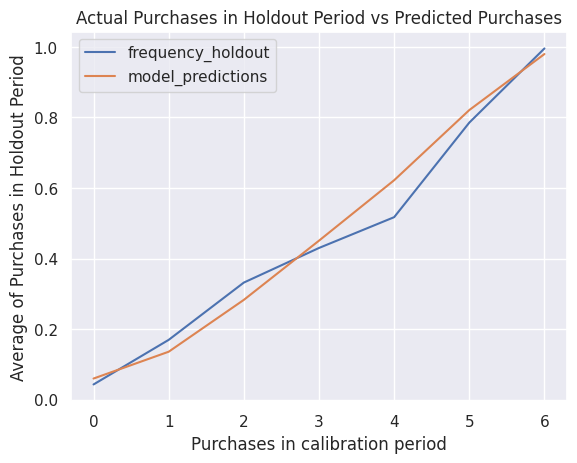

In [17]:
bgf2 = BetaGeoFitter(penalizer_coef=0.0)
bgf2.fit(rfm_cal_holdout['frequency_cal'], rfm_cal_holdout['recency_cal'], rfm_cal_holdout['T_cal'])
plot_calibration_purchases_vs_holdout_purchases(bgf2, rfm_cal_holdout)

**Predict purchase**

In [18]:
rfm_cal_holdout['predicted_purchases'] = bgf2.conditional_expected_number_of_purchases_up_to_time(100, rfm_cal_holdout['frequency_cal'], rfm_cal_holdout['recency_cal'], rfm_cal_holdout['T_cal'])

In [19]:
rfm_cal_holdout

,frequency_cal,recency_cal,T_cal,monetary_value_cal,frequency_holdout,monetary_value_holdout,duration_holdout,predicted_purchases
id,,,,,,,,
1,0.0,0.0,445.0,0.000000,0.0,0.00,100.0,0.054490
2,0.0,0.0,434.0,0.000000,0.0,0.00,100.0,0.055721
3,4.0,327.0,444.0,29.677500,1.0,16.99,100.0,0.645906
4,3.0,345.0,445.0,23.723333,0.0,0.00,100.0,0.516627
5,10.0,367.0,445.0,35.628000,0.0,0.00,100.0,1.606435
...,...,...,...,...,...,...,...,...
23566,0.0,0.0,362.0,0.000000,0.0,0.00,100.0,0.065394
23567,0.0,0.0,362.0,0.000000,0.0,0.00,100.0,0.065394
23568,2.0,28.0,362.0,49.365000,0.0,0.00,100.0,0.055071


In [20]:
print('RMSE: ', mean_squared_error(rfm_cal_holdout['frequency_holdout'], rfm_cal_holdout['predicted_purchases'])**(1/2))
print('SMAPE', smape(rfm_cal_holdout['frequency_holdout'], rfm_cal_holdout['predicted_purchases']))
print('R2: ', r2_score(rfm_cal_holdout['frequency_holdout'], rfm_cal_holdout['predicted_purchases']))

RMSE:  0.6875897284052181
SMAPE 1.8425877872395369
R2:  0.452378698471089


In [21]:
sample_customer = rfm_cal_holdout.iloc[20]
sample_customer

frequency_cal               1.000000
recency_cal                12.000000
T_cal                     445.000000
monetary_value_cal         11.770000
frequency_holdout           0.000000
monetary_value_holdout      0.000000
duration_holdout          100.000000
predicted_purchases         0.050041
Name: 21, dtype: float64

In [22]:
n_transactions_pred = bgf.predict(t=100, # we set it to 26 weeks (the length of the observation period)
                                  frequency=sample_customer['frequency_cal'],
                                  recency=sample_customer['recency_cal'],
                                  T=sample_customer['T_cal'])

n_transactions_pred

0.05004104432919706

In [23]:
alive_prob = bgf.conditional_probability_alive(frequency=sample_customer['frequency_cal'],
                                               recency=sample_customer['recency_cal'],
                                               T=sample_customer['T_cal'])

alive_prob

array([0.19735123])

In [24]:
rfm_cal_holdout["n_transactions_holdout_real"]  = rfm_cal_holdout["frequency_holdout"] + 1

# the predicted number of transactions in the next 26 weeks (length of the observation period)
rfm_cal_holdout["n_transactions_holdout_pred"] = bgf.predict(t=26,
                                                    frequency=rfm_cal_holdout['frequency_cal'],
                                                    recency=rfm_cal_holdout['recency_cal'],
                                                    T=rfm_cal_holdout['T_cal'])

# comparison of the real and predicted transactions
rfm_cal_holdout[["n_transactions_holdout_real", "n_transactions_holdout_pred"]].head()

,n_transactions_holdout_real,n_transactions_holdout_pred
id,,
1,1.0,0.014422
2,1.0,0.014754
3,2.0,0.172620
4,1.0,0.137918
5,1.0,0.430468


In [25]:
RMSE = mean_squared_error(y_true = rfm_cal_holdout["n_transactions_holdout_real"],
                          y_pred = rfm_cal_holdout["n_transactions_holdout_pred"],
                          squared = False)

RMSE

1.4471661859139033